In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# numpy package
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from matplotlib import pyplot

In [17]:

# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# compute the number of labels
num_labels = np.amax(y_train) + 1
# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
# we train our network using float data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
batch_size = 128
hidden_units = 256
dropout = 0.45
data_augmentation = True
epochs = 20
max_batches = 2 * len(x_train) / batch_size


In [3]:
# this is 3-layer MLP with ReLU after each layer
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dense(num_labels))
# this is the output for one-hot vector
model.add(Activation('softmax'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


In [18]:
# loss function for one-hot vector
# use of sgd optimizer
# accuracy is good metric for classification tasks
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# validate the model on test dataset to determine generalization
# score = model.evaluate(x_test, y_test, batch_size=batch_size)
# print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    # train the network no data augmentation
    x_train = np.reshape(x_train, [-1, input_size])
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    # we need [width, height, channel] dim for data aug
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5.0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally
        height_shift_range=0.0,  # randomly shift images vertically
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    for e in range(epochs):
        batches = 0
        for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
            x_batch = np.reshape(x_batch, [-1, input_size])
            history = model.fit(x_batch, y_batch, verbose=0)
            batches += 1
            #print("Epoch %d/%d, Batch %d/%d" % (e+1, epochs, batches, max_batches))
            if batches >= max_batches:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break

Using real-time data augmentation.


/home/schandrasekhar/kerasenv/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (60000, 28, 28, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


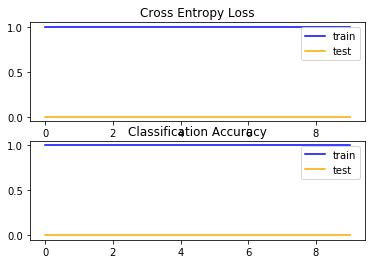

In [19]:
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['acc'], color='blue', label='train')
pyplot.plot(history.history['loss'], color='orange', label='test')
pyplot.legend()
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['acc'], color='blue', label='train')
pyplot.plot(history.history['loss'], color='orange', label='test')
pyplot.legend()
pyplot.show()
pyplot.close()


In [20]:
# Score trained model.
x_test = np.reshape(x_test, [-1, input_size])
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

 9856/10000 [============================>.] - ETA: 0sTest loss: 0.08302190386027124
Test accuracy: 0.9826
